## Constructing machine learning potential

First of all we need to get some dataset for fitting. Good example
is [this one ](https://archive.materialscloud.org/record/2020.110):

In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

--2020-10-11 22:55:57--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602449817&Signature=ipI5BxoFpZfU08isT3SnYOzzOzg%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-10-11 22:55:57--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602449817&Signature=ipI5BxoFpZfU08isT3SnYOzzOz

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In the following cell parameters which control subsequent calculations along with hyperparamters of the model are defined. 


Total amount of structures in the methane dataset is very huge, thus it is good idea to select smaller amount to speed up calculations. 


Two out of three steps of NICE requires data to be fitted. In the PCA step atomic environments are used to determine matrix of linear transformation which would allow to 
preserve the most amount of information for **this particular dataset**. In purifers eliminated correlations are also dataset specific. Though, it is absolutelly not necessary 
to use the same amount of data to fit NICE transformer and to fit subsequent machine learning model. Typically NICE transformer requires less amount of data to be fitted, and
fitting process requires noticiable amount of RAM, thus, it is good idea to restrict amount of data for this step, which is controleed by environments_for_fitting variable. 

grid defines numbers of training configurations for which error would be estimated in order to get an idea how good is the model depending on the number of training configurations. 
(yep, NICE transformer uses more data for fitting for few first point, but it is just a tutorial)

in HYPERS dictionary parameters for initial spherical expansion are defined. For more detail we refer reader to [librascal](https://github.com/cosmo-epfl/librascal) documentation. 

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:10000"    #input for ase.io.read command
test_subset = "10000:15000"     #input to ase.io.read command
environments_for_fitting = 1000    #number of environments to fit nice transfomers
grid =  [150, 200, 350, 500, 750, 1000,
         1500, 2000, 3000, 5000, 7500, 10000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}

This cell is the most important one. Our model is defined here. As was mentioned before 
NICE is the sequence of standard transformations, there each increases body order by 1. 
The classes which implements this logic are StandardBlock and StandardSequence. 

StandardSequence consist of 1) initial scaler 2) initial pca and of 3) sequence of standard blocks. 

Let's imagine uniform multiplication of spherical expansion coefficients by some constant k. In this case covariants of order k would change as *= k ^(body order). In other words relative scale of different body orders would change. This might affect subsequent regression, so it is a good idea to fix the scale in some proper way. This is done by initial scaler. It has two mods - "signal integral" and "variance". In the first case it scales coefficients such a way to make integral of squared corresponding signal over the ball to be one. In the second case it assures variance of coefficient's entries to be ones. In practice first mod gives better results. Second parameter to this class is to scale coefficients individually, i. e. separately for each environment or globally, thus preserving information about scale of signals in relation to each other. 

Initial pca is the same pca which is applied in each block, more details about it later. It is the first transformation to coefficients after initial scaler. 

As already mentioned in theory each block consist of two branches - for covariants and for invariants. Each branch consist of expansion, purification and pca step. During the expansion step in each block features of next body order are produced by Clebsch-Gordan iteration between features from the previous block and spherical expansion coefficients after initial_pca. In case of full expansion, each with each, number of features after this transformation would be incredibly huge, as it was already discussed in theory. Thus, thresholding heuristic is used. For each feature information how important it is is stored during the calculations. In standard sequence this importances are just explained variance ratios after PCA step. During expansion for each pair of covariant vectors "pair importance" is defined as the multiplication of previously discussed single feature importances, and after that only fixed amount of most important input pairs produce output. This fixed amount is controlled by num_expand parameter. If it is not specified (or set to None) full expansion, each with each, would be performed. 

The nature of purifier step was discussed in the theory. Parameter max_take controls the amount of features to take for purification from previous body orders. (Features are alwas stored in descending order of importance, and it uses first ones). If max_take is not specified (None) it would use all available features. 
One additional parameter is linear regressor to use. For example 

from sklearn.linear_model import Ridge<br>
CovariantsPurifierBoth(regressor = Ridge(alpha = 42, fit_intercept = False), max_take = 10)

or 

from sklearn.linear_model import Lars<br>
InvariantsPurifier(regressor = Lars(n_nonzero_coefs = 7), max_take = 10)

Default one is Ridge(alpha = 1e-12) without fitting intercept for covariants purifier and with fitting intercept for invariants purifier. 

***Important!*** always put fit_intercept = False to regressor in covariants purifer. Otherwise resulting features would not be covariants, since vector with constant entries is not covariant. (it is not checked automatically, since corresponding parameter might have different name from "fit_intercept")

Custom regressors can be feeded into purifiers, more details about it in tutorial "Custom regressors into purifiers"

Parameter of pca states for the number of output features. If it is not specified (None) full pca would be performed. 

Both in name of classes states for the fact that transformations are done simultaneously on even and odd features (more details about it in the tutorials "Calculating covariants" (what are even and odd features?) and "Constructor or non standard sequence" (classes to work with no separation?)). 

Individual in IndividualLambdaPCAsBoth states for the fact that transformations are independent for each lambda channel.

Since we are interested only in invariants, it is not necessary for last block to calculate covariants. Thus corresponding branch is filled with None-s.

In this example parameters of covariant and invariant branches (such as num_expand in expansioners) are not dramatically different, but in real life calculations they usually differ from each other dramatically, see examples folder. 


In [4]:
#our model:
def get_nice():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                             StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                            StandardBlock(None,
                                             None,
                                                  None,
                                                  ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 50),
                                                 InvariantsPCA(n_components = 200))
                                   ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True)
                          )

It is not necessary to always fill all transformation steps. For example the following block is valid:

<pre>
StandardBlock(ThresholdExpansioner(num_expand = 150),
              None, 
              IndividualLambdaPCAsBoth(n_components = 50), 
              ThresholdExpansioner(num_expand =300, mode = 'invariants'), 
              InvariantsPurifier(max_take = 50), 
              None)
</pre>   
  
In this case purifying step in covariants branch and PCA step in invariants branch would be ommited. Covariants and invariants branches are independent. In case of not valid combinations, such as 

<pre>
StandardBlock(None, 
              None,
              IndividualLambdaPCAsBoth(n_components = 50), 
              ...)
</pre>              

It would raise value error with the description of the problem during initialization.

All intermediate blocks must compute covariants. Block is considered as computing covariants if it contains covariants expansioner and covariants pca. The latter is required since expansioners in subsequent blocks require not only covariants themselves, but also their importances for thresholdoing. 

In this cell we read structures, get set of all species in the dataset, and calculate spherical expansion. 

all species is given by the set of int, where 1 states for H, 2 for He and so on. 

coefficients is the dictionary where keys are central species, 1 and 6 in our case, and entries are numpy arrays shaped in the  [environment_index, radial/specie index, l, m] way. 

In [5]:
train_structures = ase.io.read('methane.extxyz', 
                         index = train_subset)

test_structures = ase.io.read('methane.extxyz', 
                         index = test_subset)

all_species = get_all_species(train_structures + test_structures)
print("all species: ", all_species)
train_coefficients = get_spherical_expansion(train_structures, HYPERS, all_species)


test_coefficients = get_spherical_expansion(test_structures, HYPERS, all_species)

all species:  [1 6]


100%|██████████| 2/2 [00:00<00:00, 74.03it/s]


We are going to fit two NICE transformers on environments around H and C atoms separatelly.
the following cells create them and perfom fitting: 

In [6]:
#individual nice transformers for each atomic specie in the dataset
nice = {}
for key in train_coefficients.keys():
    nice[key] = get_nice()

In [7]:
for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compr

It is not necessary to fit different nice transformers for each central specie, see for example qm9 examples in example folder

Let's calculate representations!:

In [8]:
train_features = {}
for specie in all_species:
    train_features[specie] = nice[specie].transform(train_coefficients[specie],
                                                            return_only_invariants = True)
    
test_features = {}
for specie in all_species:
    test_features[specie] = nice[specie].transform(test_coefficients[specie],
                                                           return_only_invariants = True)

Result is nested dictionary. First level keys are central species, inner level keys are body orders. Inside are numpy arrays with shapes [environment_index, invariant_index]:

In this case number of train structures is 10k, and each consist of 4 H atoms. Thus, total amount of H centered environments is 40k

In [9]:
for key in train_features[1].keys():
    print("{} : {}".format(key, train_features[1][key].shape))

1 : (40000, 10)
2 : (40000, 200)
3 : (40000, 200)
4 : (40000, 200)


Now we need to prepare to subsequent linear regression. As it was already discussed in theory energy is extensive property, and thus it is given as sum of atomic contributions. 
Each atomic contribution depends on 1) central specie and 2) environment. Thus, it is straighforward to see that if each atomic contribution is given by linear combination of previously calculated NICE features, the structural features should have the following form - for each structure set of features is a concatenation of representations for each specie. Representation for each specie is sum of NICE representations over the atoms with this specie in structure. 

In our case representation of each environment has size 200 + 200 + 200 + 10 = 610. And we have two atomic species - H and C. Thus shape of structures features should be [number_of_structures, 610 * 2 = 1220]:

In [10]:
train_features = make_structural_features(train_features, train_structures, all_species)
test_features = make_structural_features(test_features, test_structures, all_species)
print(train_features.shape)

100%|██████████| 5000/5000 [00:00<00:00, 8821.33it/s]

(10000, 1220)


Energies are a part of the dataset we previously downloaded:

In [11]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV


And the last step is to do linear regression and plot learning curve.

In [12]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))

def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values)) ** 2))

def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)

def estimate_performance(clf, data_train, data_test, targets_train, targets_test):
    clf.fit(data_train, targets_train)
    return get_relative_performance(clf.predict(data_test), targets_test)

In [13]:
errors = []
for el in tqdm.tqdm(grid):   
    errors.append(estimate_performance(BayesianRidge(), train_features[:el],
                                       test_features, train_energies[:el],
                                       test_energies))

100%|██████████| 12/12 [00:45<00:00,  3.78s/it]


In this smallest setup best rmse appeared to be about 7%:

In [14]:
print(errors)

[0.4246769917146664, 0.42795557159896896, 0.34949830448562647, 0.23167750292004954, 0.1805004317933902, 0.16245873101544683, 0.13090501832712487, 0.1162899615967867, 0.09911964945838202, 0.08351690671342994, 0.07210771368850206, 0.06984120801871395]


learnig curve looks like this:

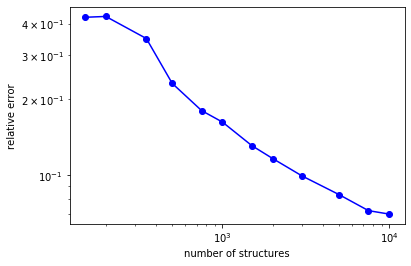

In [15]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()

The pipeline in this tutorial was designed to expose all intermediate steps, but it has one drawback - at some moment all atomic representations along with all intermediate covariants for whole dataset are explicitly stored in RAM, which might become a bottleneck for big calculations. Indeed, only structural invariant features are eventually needed, and their size is much smaller than the size of all atomic representations, especially if dataset consist of large molecules. Thus, it is a good idea to calculate structural features by small blocks and get rid of atomic representations for each block immediatelly. For this purpose there is function nice.utilities.transform_sequentially. It has block_size parameter which controls the size of each chunk. The higher is this chunk the more RAM is required for calculations. But, on the other side for very small chunks slow python loops over lambda channels with invoking separate python classes for each lambda channel might become a bottleneck (all the other indices are handled either by numpy vectorization either by cython loops). Thus, transforming time per single environments monotonically decrease with the block_size and eventually goes to saturation. Default value for block_size parameter should be fine in most cases.

Full example can be found in examples/methane_home_pc or in examples/qm9_home_pc. Other than that and absence of markdown comments these notebooks are almost identical to this tutorial (in qm9 single nice transformer is used for all central species). Thus, we recommend to pick one of them as the code snippet. 